# **You Matter, Words Matter: A Suicide Prevention Tool**
**DATA103 S11 Group 4**
- GOZON, Jean Pauline D.
- JAMIAS, Gillian Nicole A.
- MARCELO Andrea Jean C. 
- REYES, Anton Gabriel G.
- VICENTE, Francheska Josefa

# **Introduction**

Crosby et al. (2011) defined *suicide* as death caused by intentional self-directed injury. Suicidal behavior, which includes suicide and suicide attempts, is a global public health concern. Determining an individual’s risk of suicide is challenging because of the involvement of multiple risk factors. Biological (including genetics), psychological (such as particular personality traits), clinical (such as comorbid psychiatric illness), and social and environmental factors all play a role in the development of suicide risk (Turecki et al., 2019). Using machine learning models in suicide detection can provide valuable information for social media and search engine algorithms. A survey conducted by the Pew Research Center reports that teens (ages 13 to 17) view social media as a method to strengthen their friendships and provide emotional support (Anderson & Jiang, 2018). Simultaneously, social media is a platform where drama can arise, and teens feel pressured to post certain types of content, according to the same survey. Nowadays, interactions and habits of an individual, such as posting and searching specific terms, are studied or analyzed to better understand the needs of the individual.


With our project, we aim to classify suicide and non-suicide text using four different datasets combined into one. The datasets originated from Twitter, Reddit, and Kaggle. The results gathered from this project can be used to supplement the prevention of suicide. For example, individuals whose texts that classified as suicide can be presented with appropriate suicide prevention Web pages or mental health resources. Additionally, social media algorithms could be prevented from suggesting triggering content to these people. 

# **Requirements and Imports**

## **Basic** Libraries

* `numpy` contains a large collection of mathematical functions
* `pandas` contains functions that are designed for data manipulation and data analysis

In [1]:
import numpy as np
import pandas as pd
import datasets

## **Visualization** Libraries

* `matplotlib.pyplot` contains functions to create interactive plots
* `seaborn` is a library based on matplotlib that allows for data visualization
* `spacy` is a Python-based open-source library used in processing text data. 
* `wordcloud` contains functions for generating wordclouds from text data 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import WordCloud, STOPWORDS

## **`Natural Language Processing`** Libraries
* `re` is a module that allows the use of regular expressions
* `nltk` provides functions for processing text data
* `stopwords` is a corpus from NLTK, which includes a compiled list of stopwords
* `Counter` is from Python's collections module, which is helpful for tokenization
* `string` contains functions for string operations
* `TFidfVectorizer` converts the given text documents into a matrix, which has TF-IDF features
* `CountVectorizer` converts the given text documents into a matrix, which has the counts of the tokens

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk import ngrams

from collections import Counter
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

Running this cell will download the following [`NLTK`](https://www.nltk.org/) packages to help us in preprocessing and cleaning the datasets to be used in this project.

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ajmarcelo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ajmarcelo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ajmarcelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ajmarcelo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ajmarcelo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## **`Machine Learning`** Libraries

* [`torch`](https://pypi.org/project/torch/) this is an open source ML library for deep neural network creation.
* [`transformers`](https://huggingface.co/docs/transformers/index)contains pre-trained models.
* [`pickle`](https://docs.python.org/3/library/pickle.html) is a module that can serialize and deserialize objects. In this notebook, it is used to save and load models.
* [`evaluate`](https://pypi.org/project/evaluate/) facilitates the process of evaluating and comparing models and ensures that their performance is reported in a more standardized and simplified manner.

Comment out the code and run the next cell if you haven't installed the [`transformers`](https://huggingface.co/docs/transformers/index) and the [`vaderSentiment`](https://pypi.org/project/vaderSentiment/).

In [5]:
# !pip install transformers
# !pip install vaderSentiment

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_lightning.callbacks import ProgressBarBase, RichProgressBar

from transformers import AutoTokenizer, BertTokenizerFast, AutoModelForSequenceClassification, TrainerCallback, TrainingArguments, Trainer

from sklearn.metrics import f1_score, roc_auc_score, hamming_loss, accuracy_score
from transformers import EvalPrediction
import evaluate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import pickle

## **Google Drive**
* `google.colab` a library that allows the colab notebook to mount the google drive

## **Dataset Files**

The following `.csv` files will be used in this project:
* [`Suicide_Detection.csv`](https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch/code) contains the text itself and the two classes namely suicide and non-suicide. Retrieved from the "Suicide and Depression Detection" in Kaggle
* [`twitter-suicidal-intention-dataset.csv`](https://github.com/laxmimerit/twitter-suicidal-intention-dataset) similar to `Suicide_Detection.csv` but intention is numbered. For the intention column, 1 means tweet is suicidal and 0 means it is not. Retrieved from github.
* [`500_anonymized_Reddit_users_posts_labels.csv`](https://www.kaggle.com/datasets/thedevastator/c-ssrs-labeled-suicidality-in-500-anonymized-red) contains text from a post and the label of intention. (4 labels available)
* [`suicide notes.csv`](https://www.kaggle.com/datasets/mohanedmashaly/suicide-notes) contains text of suicide notes but it does not have a column labelling the notes as suicidal

## **Data Collection**

In this section, we will be importing the different `.csv` files from different sources into the notebook using the [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function. After this, the [`head`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) function will also be used to check the first few rows of the dataset. This will let us have a glance on the features of each dataset and what type of data each feature has.

### Importing [`Suicide Detection Data`](https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch/code)

After obtaining our own copy through downloading the dataset from **Kaggle**, we will load the data by using the `read_csv`. You may also click the `Suicide Detection Data` from the header to be redirected to the source of the dataset.

In [7]:
watch_df = pd.read_csv('data/Suicide_Detection.csv')
watch_df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


### Importing [`Twitter Suicide Intention Data`](https://github.com/laxmimerit/twitter-suicidal-intention-dataset)

In this case, we can access the data by getting its url from its **GitHub** source. Then, we can still use the `read_csv` function to load the dataset by feeding the url to the function. To access the source of the dataset, you can click on the `Twitter Suicide Intention Data` in the header.

In [8]:
url = "https://raw.githubusercontent.com/laxmimerit/twitter-suicidal-intention-dataset/master/twitter-suicidal_data.csv"
twit_df = pd.read_csv(url)
twit_df.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


### Importing [`Suicide Notes Data`](https://www.kaggle.com/datasets/mohanedmashaly/suicide-notes)

Clicking on the link labeled `Suicide Notes Data` in the header will lead you to the dataset's source. Once downloaded the dataset from **Kaggle**, we can load it using the `read_csv` function.

In [9]:
notes_df = pd.read_csv("data/suicide notes.csv")
notes_df.head()

,id,text
0,1,I have to put this in writing somehow so I sti...
1,2,I've made my peace with the fact that I'm goin...
2,3,I really want help now i just cant so this any...
3,4,I can't think of any reason to stay. I have no...
4,5,NaN


### Importing [`Suicidality on Reddit Data`](https://www.kaggle.com/datasets/thedevastator/c-ssrs-labeled-suicidality-in-500-anonymized-red)

The dataset's source can be accessed by clicking on the `Suicidality on Reddit Data` in the header. After obtaining the dataset from **Kaggle**, we can use the `read_csv` function to load it.

In [10]:
anon_df = pd.read_csv("data/500_anonymized_Reddit_posts.csv")
anon_df.head()

,User,Post,Label
0,user-0,"['Its not a viable option, and youll be leavin...",Supportive
1,user-1,['It can be hard to appreciate the notion that...,Ideation
2,user-2,"['Hi, so last night i was sitting on the ledge...",Behavior
3,user-3,['I tried to kill my self once and failed badl...,Attempt
4,user-4,['Hi NEM3030. What sorts of things do you enjo...,Ideation


To check all the individual classes, the [`unique`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) function was called to see all distinct values. The `notes.df` does not have any additional column aside from text so there are no unique values to be checked.

In [11]:
print(watch_df["class"].unique())
print(twit_df["intention"].unique())
print(anon_df["Label"].unique())

['suicide' 'non-suicide']
[1 0]
['Supportive' 'Ideation' 'Behavior' 'Attempt' 'Indicator']


## **Description of the Dataset**

Using the [`shape`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html) function, the number of rows and columns can be obtained for all dataframes collected. The `watch_df`  has 232074 rows (instances) and three (3) columns (features). The `twit_df` has 9119 rows (instances) and two (2) columns (features) The `anon_df` has 500 rows (instances) and three (3) columns (features). The `notes_df` has 498 rows (instances) and two (2) columns (features). An instance in our dataset represents a text and its categories (labels).

In [12]:
#getting the shape of the four datasets
display(watch_df.shape, twit_df.shape, anon_df.shape, notes_df.shape)

(232074, 3)

(9119, 2)

(500, 3)

(498, 2)

The [`info`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) function provides information about a DataFrame including the index data type and columns, non-null values, and memory usage. The main reason for running this function is to see the data types of all the columns in each Dataframe.

In [13]:
print(watch_df.info(), twit_df.info(), anon_df.info(), notes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   User    500 non-null    object
 1   Post    500 non-null    object
 2   Label   500 non-null    object
dtypes: object(3)
memory usage: 11.8+

After seeing the number of features in each column per dataset, dataframes `watch_df`, `twit_df`, and `anon_df` are complete. However, dataframe `notes_df` contains null values. 

## **Data Preprocessing**

For data pre-processing, we checked if the four dataframes we collected: (1) has NaN values, (2) has data type uniformity in a class column such as non-suicidial text set to a value of zero and suicidual text set to a value of one. The four dataframes respective text and class columns were merged into one dataframe to be used in different models.

### DataFrames

Since the dataframe `notes_df` has null values, we will get rid of those rows using panda's [`dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html?highlight=dropna#pandas.DataFrame.dropna) function. Setting the axis to 0 allows us to drop rows which contain missing values. Additionally, the how parameter set to any causes that row to be removed if there is at least 1 null value present in that row. Having inplace equal to true modifies the exisiting Dataframe.

In [14]:
notes_df.dropna(axis = 0, how = "any", inplace=True)

After checking the total number of null values  in the whole `notes_df` we can see it is equal to zero.

In [15]:
notes_df.isnull().sum().sum()

0

For some of the dataframes, the `user`, `id`, and `unnamed column` would not be needed and therefore would be dropped.

In [16]:
anon_df = anon_df.drop("User", axis = 1)
notes_df = notes_df.drop("id", axis = 1)
watch_df = watch_df.drop("Unnamed: 0", axis = 1)

In [17]:
display("anon_df",anon_df.columns, "notes_df", notes_df.columns, "watch_df", watch_df.columns)

'anon_df'

Index(['Post', 'Label'], dtype='object')

'notes_df'

Index(['text'], dtype='object')

'watch_df'

Index(['text', 'class'], dtype='object')

In [18]:
display("anon_df",anon_df.head(), 
        "notes_df", notes_df.head(), 
        "twit_df", twit_df.head(), 
        "watch_df", watch_df.head())

'anon_df'

,Post,Label
0,"['Its not a viable option, and youll be leavin...",Supportive
1,['It can be hard to appreciate the notion that...,Ideation
2,"['Hi, so last night i was sitting on the ledge...",Behavior
3,['I tried to kill my self once and failed badl...,Attempt
4,['Hi NEM3030. What sorts of things do you enjo...,Ideation


'notes_df'

,text
0,I have to put this in writing somehow so I sti...
1,I've made my peace with the fact that I'm goin...
2,I really want help now i just cant so this any...
3,I can't think of any reason to stay. I have no...
5,"Hi, it's my first post here, I'm new in this c..."


'twit_df'

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


'watch_df'

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


After dropping the unecessary columns, it was then time to convert the values for the labeling columns so that once the dataframes are joined, there wouldn't be any further complications. 

Reviewing the columns of all the datasets we imported

In [19]:
display("anon_df columns", list(anon_df.columns),"notes_df columns", list(notes_df.columns),
        "twit_df columns", list(twit_df.columns), "watch_df columns", list(watch_df.columns))

'anon_df columns'

['Post', 'Label']

'notes_df columns'

['text']

'twit_df columns'

['tweet', 'intention']

'watch_df columns'

['text', 'class']

Creating a copy of `watch_df` before modifying the values to match `twit_df` (1 means text is suicidal and 0 means it is not) through the [`copy`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html) function.

In [20]:
integerwatch_df = watch_df.copy(deep=True)

Using pandas [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html?highlight=replace#pandas.DataFrame.replace) function to change multiple values with multiple new values for an individual DataFrame column

In [21]:
integerwatch_df['class'] = integerwatch_df['class'].replace(['suicide', 'non-suicide'], ['1', '0'])

In [22]:
integerwatch_df.head() #checking if the replace function reflected

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


Using [`info`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) to check the datatypes of the dataframe `intgerwatch_df`

In [23]:
integerwatch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


Using pandas [`astype`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html?highlight=astype#pandas.DataFrame.astype) function allows us to convert the obj data type in the class column to integer for uniformity with other dataframes

In [24]:
integerwatch_df['class'] = integerwatch_df['class'].astype('int')

Creating a copy of `notes_df` before modifying the values to match twit_df (1 means text is suicidal and 0 means it is not) through the [`copy`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html) function

In [25]:
integerwatch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


In [26]:
integernotes_df = notes_df.copy(deep=True)

Creating a new column named class and setting it to have a constant value of 1 since all texts are posted by users with  suicidal thoughts

In [27]:
integernotes_df['class'] = 1

In [28]:
integernotes_df.head() #checking if the new class column was addded

,text,class
0,I have to put this in writing somehow so I sti...,1
1,I've made my peace with the fact that I'm goin...,1
2,I really want help now i just cant so this any...,1
3,I can't think of any reason to stay. I have no...,1
5,"Hi, it's my first post here, I'm new in this c...",1


Creating a copy of `twit_df` before modifying the column names to match `integerwatch_df` and `integernotes_df`

In [29]:
new_twit = twit_df.copy(deep=True)

To match `new_twit` to the other Dataframes, renaming was done using pandas [`rename`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html?highlight=rename#pandas.DataFrame.rename) function. It uses a dictionary of new and old column names. Inplace set to true modified the existing Dataframe.

In [30]:
new_twit.rename(columns={"tweet": "text", "intention": "class"}, inplace=True)

In [31]:
new_twit.head() #checking if column names are renamed

,text,class
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


For `anon_df`, there are five unique values with their respective counts:

In [32]:
anon_df.Label.value_counts()

Ideation      171
Supportive    108
Indicator      99
Behavior       77
Attempt        45
Name: Label, dtype: int64

Columns for `anon_df` were renamed for consistency with the other dataframes.

In [33]:
anon_df.rename(columns={"Post": "text", "Label": "class"}, inplace=True)

Copying `anon_df` before modifying other values.

In [34]:
intanon_df = anon_df.copy(deep =  True)

Using pandas [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html?highlight=replace#pandas.DataFrame.replace)  function to change multiple values with multiple new values for an individual DataFrame column. For `intanon_df` the 5 values were replaced with a corrosponding `1` or `0` value.

In [35]:
intanon_df['class'] = intanon_df['class'].replace(['Ideation', 'Indicator','Behavior','Attempt','Supportive'], ['1','1','1','1','0'])

Using the [`astype`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html?highlight=astype#pandas.DataFrame.astype) function to convert the `class` value's types into `int` or an `integer` type. 

In [36]:
intanon_df['class'] = intanon_df['class'].astype('int')

Looking at the tail of `intanon_df` to check if the `class` values were replaced and converted accordingly. 

In [37]:
intanon_df.tail()

,text,class
495,"['Its not the end, it just feels that way. Or ...",0
496,"['It was a skype call, but she ended it and Ve...",1
497,['That sounds really weird.Maybe you were Dist...,0
498,['Dont know there as dumb as it sounds I feel ...,1
499,"['&gt;It gets better, trust me.Ive spent long ...",1


After changing column names for `anon_df` the following values were changed:

* Ideation = 1
* Indicatior = 1
* Behavior = 1
* Attempt = 1
* Supportive = 0

#### All dataframes

Displaying the dataframes we have now

In [38]:
display("intanon_df",intanon_df.head(), 
        "integernotes_df", integernotes_df.head(), 
        "new_twit", new_twit.head(), 
        "integerwatch_df", integerwatch_df.head())

'intanon_df'

,text,class
0,"['Its not a viable option, and youll be leavin...",0
1,['It can be hard to appreciate the notion that...,1
2,"['Hi, so last night i was sitting on the ledge...",1
3,['I tried to kill my self once and failed badl...,1
4,['Hi NEM3030. What sorts of things do you enjo...,1


'integernotes_df'

,text,class
0,I have to put this in writing somehow so I sti...,1
1,I've made my peace with the fact that I'm goin...,1
2,I really want help now i just cant so this any...,1
3,I can't think of any reason to stay. I have no...,1
5,"Hi, it's my first post here, I'm new in this c...",1


'new_twit'

,text,class
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


'integerwatch_df'

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


We switch the placement of the `text` and `class` columns in all four dataframes.

In [39]:
new_column_order = ['class', 'text'] #making the new column order

intanon_df = intanon_df[new_column_order]
integernotes_df = integernotes_df[new_column_order]
new_twit = new_twit[new_column_order]
integerwatch_df = integerwatch_df[new_column_order]

Using the [`concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html?highlight=concat#pandas.concat) function, we merge all the dataframes into one dataframe named `main_df`.

In [40]:
main_df = pd.concat([intanon_df, integernotes_df, new_twit, integerwatch_df], axis=0)

We now check if the merged dataframe for its shape.

In [41]:
display(main_df.shape , main_df["class"].unique())

(242160, 2)

array([0, 1])

Duplicate rows in the `main_df` were checked using the [`duplicated`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html) function. 

In [42]:
main_df [main_df.duplicated()]

,class,text
224,1,I attempted suicide and now stuck on bed cause...
242,1,I’ve been thinking abt it and if/when I do com...
3924,0,
4047,0,homework
4304,0,
...,...,...
8974,0,
9003,0,i am here for you
9010,0,i am here for you
9038,0,


In [43]:
main_df = main_df.drop_duplicates()
main_df

,class,text
0,0,"['Its not a viable option, and youll be leavin..."
1,1,['It can be hard to appreciate the notion that...
2,1,"['Hi, so last night i was sitting on the ledge..."
3,1,['I tried to kill my self once and failed badl...
4,1,['Hi NEM3030. What sorts of things do you enjo...
...,...,...
232069,0,If you don't like rock then your not going to ...
232070,0,You how you can tell i have so many friends an...
232071,0,pee probably tastes like salty tea😏💦‼️ can som...
232072,1,The usual stuff you find hereI'm not posting t...


## **Data Cleaning**

The group cleaned the data by removing text that we deemed inconsequential such as retweet labels, usernames, media links, square brackets, and hashtags. Moreover, whitespace was removed to easily identify cases of duplicates in the text column. 

### Removing unnecessary character sequences

We created a RegEx function to remove unnecessary character sequences that might potentially interfere with the next steps before modeling.

In [44]:
def remove_unnecessary(text):
    text = re.sub('RT', '', text) #RT
    text = re.sub('@[^\s]+', '', text) #usernames
    text = re.sub('http[^\s]+','',text) #media links
    text = re.sub(r'\[|\]', '', text) #square brackets
    text = re.sub('#[^ ]+', '', text) #hashtags
    return text

But before applying the function, a copy of the `concat` dataframe was created.

In [45]:
master = main_df.copy(deep = True)

Here, the function was applied to the `master` dataframe.

In [46]:
master['text'] = master['text'].apply(remove_unnecessary)

Checking if the `remove_unnecessary` function was applied.

In [47]:
master.head()

,class,text
0,0,"'Its not a viable option, and youll be leaving..."
1,1,'It can be hard to appreciate the notion that ...
2,1,"'Hi, so last night i was sitting on the ledge ..."
3,1,'I tried to kill my self once and failed badly...
4,1,'Hi NEM3030. What sorts of things do you enjoy...


The [`strip`](https://www.w3schools.com/python/ref_string_strip.asp) function is used to trim a string and remove any whitespace, whether leading or trailing. The apply and lambda function allows us to perform it to each element of the column named "text".

In [48]:
master['text'] = master['text'].apply(lambda x: x.strip())

Duplicate rows in the `master` dataframe were checked using the [`duplicated`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html) function. As certain rows may act as a bias in the model.

In [49]:
master [master.duplicated()]

,class,text
4224,0,oh no
6941,0,me too
7141,1,my family would be better off without me
7149,1,seems as if my family would be better off and ...
7169,1,you ll be sorry when i m gone
...,...,...
218415,0,I'm currently in AP Research and my project is...
222846,0,Happy birthday Happy birthday to anyone who h...
223415,0,Java 1.16.4 Survival Players welcomed! **IP: p...
223851,0,


Checking the shape of the `master` dataframe.

In [50]:
master.shape

(241825, 2)

Checking if there are any null values in the `master` dataframe.

In [51]:
master.isnull().sum().sum()

0

In [52]:
master [master.duplicated()]

,class,text
4224,0,oh no
6941,0,me too
7141,1,my family would be better off without me
7149,1,seems as if my family would be better off and ...
7169,1,you ll be sorry when i m gone
...,...,...
218415,0,I'm currently in AP Research and my project is...
222846,0,Happy birthday Happy birthday to anyone who h...
223415,0,Java 1.16.4 Survival Players welcomed! **IP: p...
223851,0,


In [53]:
master = master.drop_duplicates()
master

,class,text
0,0,"'Its not a viable option, and youll be leaving..."
1,1,'It can be hard to appreciate the notion that ...
2,1,"'Hi, so last night i was sitting on the ledge ..."
3,1,'I tried to kill my self once and failed badly...
4,1,'Hi NEM3030. What sorts of things do you enjoy...
...,...,...
232069,0,If you don't like rock then your not going to ...
232070,0,You how you can tell i have so many friends an...
232071,0,pee probably tastes like salty tea😏💦‼️ can som...
232072,1,The usual stuff you find hereI'm not posting t...


### **Converting the text in the `text` column for `main_df`**

Because we will be using `bert-base-uncased`, we will be needing the text data itself to be all lowercase.

First, we check the dataframe before we convert the text.

In [54]:
main_df.head()

,class,text
0,0,"['Its not a viable option, and youll be leavin..."
1,1,['It can be hard to appreciate the notion that...
2,1,"['Hi, so last night i was sitting on the ledge..."
3,1,['I tried to kill my self once and failed badl...
4,1,['Hi NEM3030. What sorts of things do you enjo...


We now use the [`.str.lower()`](https://www.geeksforgeeks.org/python-pandas-series-str-lower-upper-and-title/?ref=rp) function to put all the text in the `text` column to lowercase. After that, we check if the function was applied.

In [55]:
# main_df['text'] = main_df['text'].str.lower()

#master['text'] = master['text'].str.lower()
#un-comment the line above if the other dataframe needs to be lowercase as well.

In [56]:
main_df.head()

,class,text
0,0,"['Its not a viable option, and youll be leavin..."
1,1,['It can be hard to appreciate the notion that...
2,1,"['Hi, so last night i was sitting on the ledge..."
3,1,['I tried to kill my self once and failed badl...
4,1,['Hi NEM3030. What sorts of things do you enjo...


Checking if there are any null values in the `master` dataframe.

In [57]:
main_df.isnull().sum().sum()

0

### **Lemmatizing text in master df**

In [58]:
lemmatized_df = master.copy(deep=True)

In [59]:
lemmatized_df.head()

,class,text
0,0,"'Its not a viable option, and youll be leaving..."
1,1,'It can be hard to appreciate the notion that ...
2,1,"'Hi, so last night i was sitting on the ledge ..."
3,1,'I tried to kill my self once and failed badly...
4,1,'Hi NEM3030. What sorts of things do you enjoy...


In [60]:
wordnet_lem = WordNetLemmatizer()

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)
lemmatized_df['lemmatized_text'] = lemmatized_df['text'].apply(lemmatize_words)

In [61]:
lemmatized_df.head()

,class,text,lemmatized_text
0,0,"'Its not a viable option, and youll be leaving...","'Its not a viable option, and youll be leave y..."
1,1,'It can be hard to appreciate the notion that ...,'It can be hard to appreciate the notion that ...
2,1,"'Hi, so last night i was sitting on the ledge ...","'Hi, so last night i be sit on the ledge of my..."
3,1,'I tried to kill my self once and failed badly...,'I try to kill my self once and fail badly cau...
4,1,'Hi NEM3030. What sorts of things do you enjoy...,'Hi NEM3030. What sort of things do you enjoy ...


### **Saving of Cleaned Data to CSV files**

Using the [`to_csv`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html) function allows us to save a copy of the Dataframe in a csv format 

In [62]:
lemmatized_df.to_csv('lemmatized_with_char_seq_removal.csv', index = False)

In [63]:
main_df.to_csv('cleaned_data.csv', index = False)

In [64]:
master.to_csv('cleaned_data_with_char_seq_removal.csv', index = False)

## **Feature Engineering**

As we cannot directly feed the text data as input to the machine learning models, we have to convert it into the format that they can understand—numbers.

### Splitting the Dataset into **`Train`**, **`Validation`**, and **`Test`** Split
Let us first define the **X** (input) and **y** (target/output) of our model. This is done to allow the stratifying of the data when it is split into the train, val and test.

The **X** (input) can be retrieved by getting the `text` column in the original dataset.

In [65]:
X = master ['text']
X

0         'Its not a viable option, and youll be leaving...
1         'It can be hard to appreciate the notion that ...
2         'Hi, so last night i was sitting on the ledge ...
3         'I tried to kill my self once and failed badly...
4         'Hi NEM3030. What sorts of things do you enjoy...
                                ...                        
232069    If you don't like rock then your not going to ...
232070    You how you can tell i have so many friends an...
232071    pee probably tastes like salty tea😏💦‼️ can som...
232072    The usual stuff you find hereI'm not posting t...
232073    I still haven't beaten the first boss in Hollo...
Name: text, Length: 241738, dtype: object

Meanwhile, the **y** value (i.e., the value that we would be "feeding" our models) is the `class` column. 

In [66]:
y = master ['class']
y

0         0
1         1
2         1
3         1
4         1
         ..
232069    0
232070    0
232071    0
232072    1
232073    0
Name: class, Length: 241738, dtype: int64

Now that we have declared the input and the target output of our models, we can use the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to divide the dataset into two splits. Some things to note are: (1) the split is stratified based on the **y values**, (2) the value of the random state was set to 42 for reproducibility, and (3) the dataset is shuffled.

First, let us create the train and test set. The test set is made up of 20% of the original dataset, which infers that the second split is 80% of the original. 

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42, 
                                                    shuffle = True)

Second, we will be splitting the remaining 80% of the original dataset into two: the train and val sets. The train set will be 90% of the second split, while the val set will be 10% of it. 

In [68]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size = 0.1,
                                                  stratify = y_train,
                                                  random_state = 42, 
                                                  shuffle = True)

To check if the shapes of the input and output are the same, we will be looking at the shapes of the resulting DataFrame.

In [69]:
print('Train')
print('Input  shape: ', X_train.shape)
print('Output shape: ', y_train.shape, '\n')

print('Val')
print('Input  shape: ', X_val.shape)
print('Output shape: ', y_val.shape, '\n')

print('Test')
print('Input  shape: ', X_test.shape)
print('Output shape: ', y_test.shape, '\n')

Train
Input  shape:  (174051,)
Output shape:  (174051,) 

Val
Input  shape:  (19339,)
Output shape:  (19339,) 

Test
Input  shape:  (48348,)
Output shape:  (48348,) 



#### **Tokenizing with NLTK**

We get the `RegexpTokenizer` by creating a tokenizer.

In [70]:
main_df['text'] = main_df['text'].astype(str).str.lower()
regexp = RegexpTokenizer('\w+')

We create a new column in the `nltk_concat` dataframe to apply the tokenized text.

In [71]:
main_df['text_token']=main_df['text'].apply(regexp.tokenize)

Creating a copy of the `nltk_concat` dataframe and renaming it to be consistent with the other tokenized dataframes.

In [72]:
nltk_df = main_df.copy(deep = True)

We display the head of the dataframe to see the result of the tokenizer.

In [73]:
nltk_df.head()

,class,text,text_token
0,0,"['its not a viable option, and youll be leavin...","[its, not, a, viable, option, and, youll, be, ..."
1,1,['it can be hard to appreciate the notion that...,"[it, can, be, hard, to, appreciate, the, notio..."
2,1,"['hi, so last night i was sitting on the ledge...","[hi, so, last, night, i, was, sitting, on, the..."
3,1,['i tried to kill my self once and failed badl...,"[i, tried, to, kill, my, self, once, and, fail..."
4,1,['hi nem3030. what sorts of things do you enjo...,"[hi, nem3030, what, sorts, of, things, do, you..."


### Tokenizing with TF-IDF Vectorizer


Now, we can proceed with tokenizing our input. To do this, we first create an instance of a [`TF-IDF Vectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with default values for its parameter.

In [74]:
tfidf_vectorizer = TfidfVectorizer()

We make another vectorizer object that takes the top 5000 features.

In [75]:
tfidf_vectorizer_5000 = TfidfVectorizer(max_features = 5000)

**Train Data**

With the created vectorizer, we can now use the [`fit_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform) function, which will learn the vocabulary and the inverse document frequency from the data provided, and then create a document-term matrix using the same data.

In [76]:
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [77]:
tfidf_train_5000 = tfidf_vectorizer_5000.fit_transform(X_train)

**Validation Data**

Using the [`transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.transform) function, we will be creating a document-term matrix for the validation set. 

In [78]:
tfidf_val = tfidf_vectorizer.transform(X_val)

In [79]:
tfidf_val_5000 = tfidf_vectorizer_5000.transform(X_val)

**Test Data**

Next, we will also [`transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.transform) our test data into a document-term matrix.

In [80]:
tfidf_test = tfidf_vectorizer.transform(X_test)

In [81]:
tfidf_test_5000 = tfidf_vectorizer_5000.transform(X_test)

#### Tokenizing with Count Vectorizer

Like what we did in for the  [`TF-IDF Vectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), an instance of a [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) will be created.

In [82]:
count_vectorizer = CountVectorizer()

We make another vectorizer object that takes the top 5000 features.

In [83]:
count_vectorizer_5000 = CountVectorizer(max_features = 5000)

**Train Data**

As we have already created a [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), we can already learn the vocabulary from the train set and get the document-term matrix using the [`fit_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform) function. 

In [84]:
count_train = count_vectorizer.fit_transform(X_train)

In [85]:
count_train_5000 = count_vectorizer_5000.fit_transform(X_train)

**Validation Data**

Next, using the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) that has learned the vocabulary, we will be [`transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.transform)ing the validation set into a document-term matrix. 

In [86]:
count_val = count_vectorizer.transform(X_val)

In [87]:
count_val_5000 = count_vectorizer_5000.transform(X_val)

**Test Data**

Last, the test set will also be [`transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.transform)ed into the form that the models can understand—which in this case, a document-term matrix.

In [88]:
count_test = count_vectorizer.transform(X_test)

In [89]:
count_test_500 = count_vectorizer.transform(X_test)

# **Exploratory Data Analysis (EDA)**

## **EDA Questions**
The following questions that will be used to explore `master`, which is the combined dataset:
1. What are the most occurring words under the two classes (Non-Suicide and Suicide)?
2. What is the length average of the statements per class?
3. Are there statements that contain the word "suicide" but not under the suicide class?
4. Are there non-suicide statements containing the top 3 most frequent words in the suicide texts?
5. What are the sentiment score of the statements per class?

First, let's make a copy of the `master` dataframe which contains the combined and tokenized dataset. The copy of the dataset will be named as **`eda`**.

In [90]:
# master - the original copy of the combined and tokenized dataset

eda = master[['class','text']].copy(deep=True)

Next, the `eda` dataframe will be separated into their respective classes: **`ns`** for **non-suicide (class = 0)** and **`s`** for **suicide (class = 1)**.

In [91]:
ns = eda[eda['class'] == 0]
s = eda[eda['class'] == 1]

## 1. What are the **`most occurring words` per class**?

To identify the most occurring words, a **word cloud** will be created for each class. Moreover, there wil be two methods of creating the word cloud that will be implemented and compared. 

The two methods are the following: 
* [**`SpaCy`**](https://spacy.io/api/doc) word cloud
* A word cloud generated with **TF-IDF**

### **Word Cloud using SpaCy**

**SpaCy** is a Python-based, free, and open-source library used for various Natural Language Processing (NLP) tasks like entity recognition, text classification, and text preprocessing. 

To start, we will be **combining the text data** under each class. By using `join()`, we will be **combining** all of the text data per class. Moreover,`" "` indicates that the text data that will be combined per class would be **separated by a whitespace**. To add, we will be using `lower()` to make sure that all texts are in **lowercase**.

In [ ]:
# Combining the texts from the Non-suicide class and separating it be whitespace
text_ns = " ".join(i for i in ns.text).lower()

# Combining the texts from the Suicide class and separating it be whitespace
text_s = " ".join(i for i in s.text).lower()

Next, we will be **generating the word cloud** per class by with the help of the *combined text data per class* from the previous step.

In [ ]:
# Generating a word cloud for Non-suicide class by using the combined text data
wordcloud_ns = WordCloud(background_color="white").generate(text_ns)

# Generating a word cloud for Suicide class by using the combined text data
wordcloud_s = WordCloud(background_color="white").generate(text_s)

Now that we have generated the word clouds for both classes, let us present the visualization of both word clouds.

Text(0.5, 1.0, 'Figure 1.2\nSUICIDE CLASS')

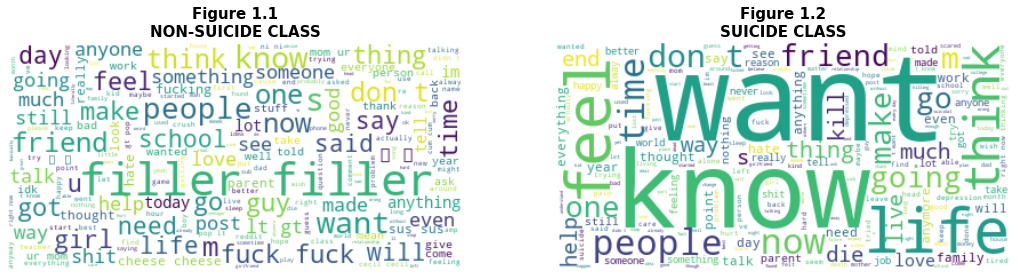

In [69]:
fig = plt.figure(figsize=(18, 13))
  
rows = 1
columns = 2
  
# Plotting the initial word cloud for Non-suicide class
fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud_ns, interpolation='bilinear')
plt.axis('off')
plt.title("NON-SUICIDE CLASS", fontsize=15, weight='bold')

# Plotting the initial word cloud for Suicide class
fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud_s, interpolation='bilinear')
plt.axis('off')
plt.title("SUICIDE CLASS", fontsize=15, weight='bold')

##### Figure 1.1. Initial Word Cloud for Each Class
As seen from the word clouds above (see Figure 1.1), there are full of unnecessary words such as *fillers* and blank spaces (*'█'*). Hence, we will be removing fillers and blank spaces to further clean the data. Moreover, we will also be **stop words** from the data to ensure that the data will only show the necessary and relevant words.

#### Excluding Stop Words, Fillers, and Blank Spaces

First we will be accessing the **SpaCy's stopwords** and **combine these with the fillers and blank spaces** seen from the initial word clouds. Then, we will be in informing the `WordCloud` function to not include these texts or characters in generating a new word cloud per class.

In [ ]:
sp = spacy.load('en_core_web_sm')

# Accesing the stopwords package from SpaCy
all_stopwords = sp.Defaults.stop_words
# List of the fillers and blank space 
new_stopwords=["filler", " ", "S", "t", "s", "m", "█"]
# Combining trhe stopwords, fillers, and blank space
comb_stopwords=list(new_stopwords)+list(all_stopwords)

# Generating the word clouds
wordcloud_ns = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_ns)
wordcloud_s = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_s)

From this, we will be **plotting the updated word clouds** which should not contain any of the texts and characters we removed from the previous step.

Text(0.5, 1.0, 'Figure 2.2\nSUICIDE CLASS')

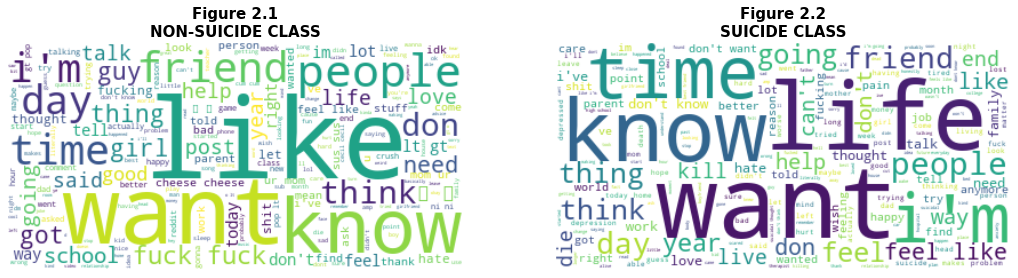

In [71]:
fig = plt.figure(figsize=(18, 13))
  
rows = 1
columns = 2
# Plotting the initial word cloud for Non-suicide class
fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud_ns, interpolation='bilinear')
plt.axis('off')
plt.title("NON-SUICIDE CLASS", fontsize=15, weight='bold')

# Plotting the initial word cloud for Suicide class
fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud_s, interpolation='bilinear')
plt.axis('off')
plt.title("SUICIDE CLASS", fontsize=15, weight='bold')

##### Figure 1.2. Updated Word Cloud for Each Class (Excluded Stopwords, Fillers, and Blank Spaces)
From the figure above, the wordclouds are cleaner. The word cloud for the non-suicide class shows the words '**like**', '**want**', and '**know**' to be the biggest words signifying that these three words are the most occurring for this class. As for the suicide class, words such as '**life**', '**want**', '**time**', '**i'm**', and '**know**' are the most occurring words.

#### Excluding Verbs and Contractions
Another set of word clouds will be generated but this time, **omitting the verbs and contractions** as most of the identified occurring words are verbs and there are contractions present in the word cloud. To get more insights from the data, verbs will be considered as stopwords. However, since current libraries do not consider verbs as stopwords, they will need to be appended to the current list of stopwords. 

Therefore, this would leave only nouns as much as possible for the next set of word clouds.

In [72]:
all_stopwords = sp.Defaults.stop_words
new_stopwords_nv=["filler", " ", "S", "t", "s", "m", "█", "want", "like", "know", "help", "tell", "talk", "thought", "feel", "said", "going", "thinking", "I'm", "think", "fuck", "fucking", "look", "i've", "think", "don", "don't", "told", "feeling", "can't", "kill", "need", "tried", "try", "leave", "i'll", "having", "got", "went", "trying", "na", "im", "shit", "gt", "It", "▯"]
comb_stopwords=list(new_stopwords_nv)+list(all_stopwords)

# Generating the word clouds
wordcloud_ns_nv = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_ns)
wordcloud_s_nv = WordCloud(stopwords=comb_stopwords, background_color="white").generate(text_s)

Now, we will **plot** the updated word clouds.

Text(0.5, 1.0, 'Figure 3.2\nSUICIDE CLASS (mostly noun)')

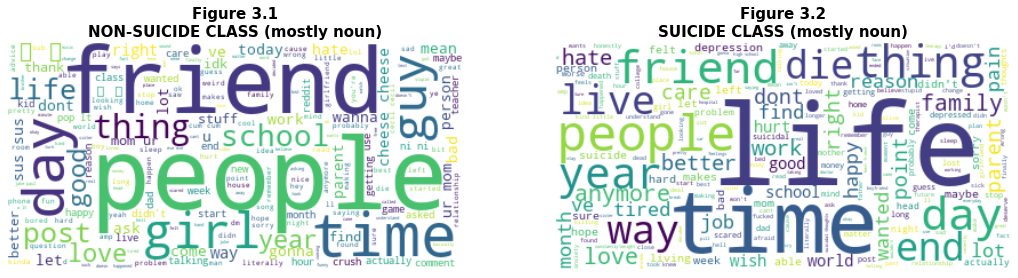

In [73]:
fig = plt.figure(figsize=(18, 13))
  
rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud_ns_nv, interpolation='bilinear')
plt.axis('off')
plt.title("NON-SUICIDE CLASS (mostly noun)", fontsize=15, weight='bold')
  
fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud_s_nv, interpolation='bilinear')
plt.axis('off')
plt.title("SUICIDE CLASS (mostly noun)", fontsize=15, weight='bold')

##### Figure 1.3. Latest Word Cloud for Each Class (Excluded Stopwords, Fillers, Blank Spaces, Verbs, and Contractions)
Based on the two word clouds presented above, the words **'people'**, **'friend'**, **'time'**, **'day'**, **'girl'**, and **'guy'** appear as the visibly large words in the non-suicide class. On the other hand, words **'life'**, **'time'**, **'people'**, **'friend'**, and **'day'** appear as the visibly large words. The large words are represents the most occuring words in each class.

### **Word Cloud using TF-IDF**

To start, we will be making a copy of the Non-suicide data **`ns`** and Suicide data **`s`**.

In [74]:
ns_tf = ns[['text']].copy(deep=True)
s_tf = s[['text']].copy(deep=True)

#### Lemmatization
Before vectorizing a dataset using TF-IDF, **lemmatization** will be done with th help of [`WordNetLemmatizer()`](https://www.nltk.org/_modules/nltk/stem/wordnet.html) to ensure that the words will be clean and reduced to the minimum possible number of words. 

To implement lemmatization, the `clean_text` function is created and will be used to clean the text and produce a noise free text.

In [75]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

ns_tf["text_clean"] = ns_tf["text"].apply(lambda s: ' '.join(re.sub("[.,!?:;-='...'@#_]", " ", s).split()))
ns_tf["text_clean"] = ns_tf["text"].apply(lambda s: ' '.join(re.sub(r'\d+', '', s).split()))

def clean_text(input_txt):
    words_ns_tf= input_txt.lower().split()
    words_ns_tf = [word for word in words_ns_tf if word not in stop_words and new_stopwords_nv] 
    words_ns_tf = [lemmatizer.lemmatize(word, pos='v') for word in words_ns_tf]
    words_ns_tf = [word for word in words_ns_tf if len(word) > 2]
    noise_free_text = " ".join(words_ns_tf) 
    return noise_free_text

ns_tf["text_clean"] = ns_tf["text_clean"].apply(lambda s: clean_text(s))


s_tf["text_clean"] = s_tf["text"].apply(lambda s: ' '.join(re.sub("[.,!?:;-='...'@#_]", " ", s).split()))
s_tf["text_clean"] = s_tf["text"].apply(lambda s: ' '.join(re.sub(r'\d+', '', s).split()))

def clean_text_s(input_txt):
    words_s_tf= input_txt.lower().split()
    words_s_tf = [word for word in words_s_tf if word not in stop_words and new_stopwords_nv] 
    words_s_tf = [lemmatizer.lemmatize(word, pos='v') for word in words_s_tf]
    words_s_tf = [word for word in words_s_tf if len(word) > 2]
    noise_free_text = " ".join(words_s_tf) 
    return noise_free_text

s_tf["text_clean"] = s_tf["text_clean"].apply(lambda s: clean_text(s))

#### Vectorization
After the texts are lemmatized, the [`TF-IDF vectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) is implemented on the two dataframes. Moreover, there will be a limit of 50 for the [`max_features`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) value to obtain only the **top 50 words with the highest TF-IDF score**.

In [76]:
tfidf_stop_words = text.ENGLISH_STOP_WORDS.union(["ll", "gt", "lt", "filler", "don", "ve"])

# Initialization of TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=tfidf_stop_words, max_features=50)

# Implementing vectorization per class lemmatized data
df_vec_ns = tfidf_vectorizer.fit_transform(ns_tf["text_clean"])
df_vec_s = tfidf_vectorizer.fit_transform(s_tf["text_clean"])

From here, the **matrix** from the result will be **converted into a dataframe**.

In [ ]:
df_ns_tf = pd.DataFrame(df_vec_ns.toarray(), columns=tfidf_vectorizer.get_feature_names())
df_s_tf = pd.DataFrame(df_vec_s.toarray(), columns=tfidf_vectorizer.get_feature_names())

Let us view the result data for Non-suicide class.

In [78]:
df_ns_tf

,anymore,bad,better,care,come,day,die,dont,end,family,...,thing,things,think,time,try,want,way,work,year,years
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.199469,0.000000,0.000000,0.000000,0.0,...,0.000000,0.199968,0.000000,0.227638,0.000000,0.0,0.000000,0.000000,0.515685,0.0
1,0.018715,0.040662,0.000000,0.000000,0.264262,0.322539,0.000000,0.000000,0.016976,0.0,...,0.198749,0.129339,0.000000,0.073618,0.020138,0.0,0.255108,0.040981,0.083386,0.0
2,0.000000,0.000000,0.031524,0.057572,0.661393,0.215266,0.033530,0.000000,0.000000,0.0,...,0.178564,0.134879,0.000000,0.061417,0.000000,0.0,0.070942,0.068378,0.000000,0.0
3,0.048418,0.000000,0.000000,0.000000,0.341848,0.041724,0.051991,0.000000,0.000000,0.0,...,0.039554,0.209141,0.000000,0.190464,0.104199,0.0,0.110002,0.106026,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.168856,0.000000,0.000000,0.177745,0.0,...,0.000000,0.169279,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.625511,0.000000,0.0,...,0.000000,0.000000,0.670473,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
121262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
121263,0.000000,0.000000,0.593332,0.000000,0.000000,0.000000,0.000000,0.585735,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
121264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


From this, we can view the **frequency score of each word (from the top 50 words)** for each data point from the **Non-suicide** class.

Now, let us view the result for the Suicide class.

In [79]:
df_s_tf

,anymore,bad,better,care,come,day,die,dont,end,family,...,thing,things,think,time,try,want,way,work,year,years
0,0.000000,0.088231,0.052377,0.054202,0.303706,0.050904,0.023947,0.271204,0.046524,0.051574,...,0.057558,0.255047,0.188668,0.326694,0.065223,0.016092,0.227991,0.052759,0.000000,0.048961
1,0.000000,0.000000,0.073856,0.076429,0.000000,0.000000,0.067534,0.478025,0.000000,0.000000,...,0.243483,0.431564,0.000000,0.172749,0.061313,0.136142,0.214324,0.074394,0.000000,0.000000
2,0.000000,0.000000,0.237759,0.000000,0.250661,0.057768,0.000000,0.153887,0.052797,0.000000,...,0.000000,0.057888,0.042822,0.185373,0.148036,0.146091,0.114993,0.000000,0.131217,0.055563
3,0.000000,0.000000,0.178957,0.000000,0.000000,0.347849,0.000000,0.463310,0.317917,0.000000,...,0.000000,0.348566,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.019624,0.023666,0.105370,0.174464,0.066653,0.061444,0.038540,0.463756,0.037438,0.103755,...,0.162108,0.061571,0.182185,0.016431,0.139961,0.116540,0.061155,0.106138,0.046522,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.273332,0.000000,...,0.000000,0.000000,0.443374,0.239919,0.000000,0.000000,0.000000,0.000000,0.000000,0.287647
120890,0.082286,0.049618,0.088365,0.274330,0.046580,0.085881,0.161603,0.000000,0.078491,0.000000,...,0.000000,0.086058,0.159150,0.103343,0.403473,0.135740,0.085476,0.133514,0.097536,0.041301
120891,0.000000,0.000000,0.202884,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.197586,0.000000,0.316365,0.673718,0.000000,0.000000,0.000000,0.000000,0.000000
120892,0.000000,0.135475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214307,0.000000,...,0.132566,0.000000,0.000000,0.282164,0.000000,0.000000,0.116690,0.000000,0.000000,0.000000


From this, we can view the **frequency score of each word from the top 50 words** for each data point from the **Suicide** class.

Now, let us view the top 50 words that are selected and rank them by the **total amount of their frequency scores** in each data point per class. 

The [`sum()`](https://www.programiz.com/python-programming/methods/built-in/sum) function will be used to **total the "presence" value of a word** to all the data points per class. After this, the [`sort_values()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) will be used to **rank the words in ascending** order based on their total presence values.

In [80]:
tf_idf_counter = df_ns_tf.T.sum(axis=1).sort_values(ascending=False)
tf_idf_counter_s = df_s_tf.T.sum(axis=1).sort_values(ascending=False)

Now, let us view the **ranking** of words for the **Non-suicide** class.

In [81]:
tf_idf_counter

know       11838.020363
way         7975.060922
help        6988.792915
live        6612.499435
say         6366.087005
thing       6096.601208
need        5933.045015
end         5661.704519
day         5364.829250
point       5362.027726
things      5110.062110
care        4996.662915
really      4708.235453
fuck        4686.270498
make        4355.445778
friends     4226.661531
stop        4157.235712
school      3921.248574
suicide     3902.946025
hate        3796.547179
want        3537.946739
leave       3533.388795
anymore     3383.492277
time        3255.435648
better      3170.062212
dont        3142.607186
family      3125.000344
shit        3112.644711
like        3102.706878
think       3025.285588
start       2953.857600
person      2919.710821
kill        2895.809223
try         2667.765766
die         2560.936570
years       2535.384494
right       2527.442039
feel        2515.474485
bad         2404.421191
talk        2351.108565
year        2335.346631
job         2330

Next, let us now view the **ranking** of words for the **Suicide** class.     

In [82]:
tf_idf_counter_s

want       16864.011337
feel       15606.073424
like       13612.465122
know       13372.509934
life       12813.800497
think      11653.029709
time        9592.332358
make        9461.104930
fuck        9172.040305
people      9031.921850
kill        8761.546802
try         8675.640420
really      8456.806600
help        8187.339563
live        8064.291818
die         7952.444767
end         7540.686179
tell        7172.089654
anymore     7122.383827
say         6972.835274
suicide     6815.315675
talk        6616.088131
friends     6503.504370
need        6492.449396
years       6439.449962
day         6242.139509
love        6012.897995
way         5914.047785
work        5827.385292
things      5710.774699
family      5672.868961
better      5647.754541
care        5405.407540
good        5233.597737
leave       5158.507699
right       4968.216119
hate        4862.281713
dont        4756.109810
come        4636.428832
point       4627.725434
stop        4586.903504
school      4538

From here, the top 5 words for the Non-suicide class are the following: 
* **know** (11838.020363)
* **way** (7975.060922) 
* **help** (6988.792915)
* **live** (6612.499435)
* **say** (6366.087005)

Meanwhile, the top 5 words for the Suicide class are the following: 
* **want** (16864.011337)
* **feel** (15606.073424)
* **like** (13612.465122)
* **know** (13372.509934)
* **life** (12813.800497)
* **think** (11653.029709)

To generate the word cloud from TF-IDF, instead of `generate()` function, `generate_from_frequencies()` is used to account for the scores of each word.

From the [WordCloud Documentation](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html), the difference between the two generate functions is:
> `generate(*text*)` - Generate word cloud from **text**.
>
> `generate_from_frequencies(*frequencies[...]*)` - Generate word cloud from **words** and **frequencies**.

In [83]:
wordcloud_tf_ns = WordCloud(width = 3000, height = 2000, random_state=1,background_color='white', colormap='Set2', collocations=False).generate_from_frequencies(tf_idf_counter)

wordcloud_tf_s = WordCloud(width = 3000, height = 2000, random_state=1,background_color='white', colormap='Set2', collocations=False).generate_from_frequencies(tf_idf_counter_s)

Now that we have generated a word cloud per class, we will now plot them to clearly see the **difference of the words among their frequency scores**. 

Text(0.5, 1.0, 'Figure 4.2\nSUICIDE CLASS')

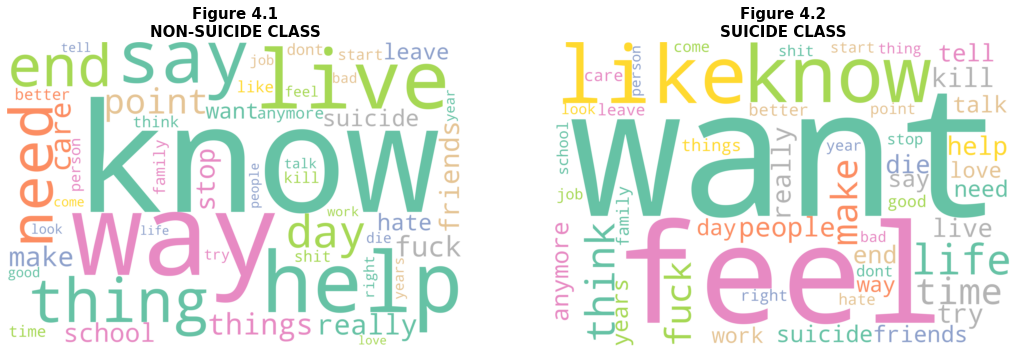

In [84]:
fig = plt.figure(figsize=(18, 13))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud_tf_ns, interpolation='bilinear')
plt.axis("off")
plt.title("NON-SUICIDE CLASS", fontsize=15, weight='bold')

fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud_tf_s, interpolation='bilinear')
plt.axis("off")
plt.title("SUICIDE CLASS", fontsize=15, weight='bold')

##### Figure 1.4. Word Cloud after TF-IDF
Evidently, as seen in figure 1.4, the  top 5 words for the *Non-Suicide class* being *know*, *way*, *help*, *live*, and *say*. On the other hand, the top 5 words for the *Suicide class* being *want*, *feel*, *like*, *know*, and *life*. However, obserivng the word cloud alone may be confusing as some words are almost as big as the top 5 words per class. Therefore,  viewing the ranking of words basedon their frequency scores is recommended when looking for the top words each class. 

With this, once again, below are the top 5 words per class with their frequency scores:

Top 5 words for the Non-suicide class are the following: 
* **know** (11838.020363)
* **way** (7975.060922) 
* **help** (6988.792915)
* **live** (6612.499435)
* **say** (6366.087005)

Top 5 words for the Suicide class are the following: 
* **want** (16864.011337)
* **feel** (15606.073424)
* **like** (13612.465122)
* **know** (13372.509934)
* **life** (12813.800497)
* **think** (11653.029709)

From this, it shows that **the top 5 words for the two classes are different** such that the only similar word from both of the classes' top 5 is the word **know**.

### SpaCy Word Cloud vs TF-IDF Word Cloud
Comparing the generated word clouds using SpaCy via counts (see Figure 1.3) and implementing TF-IDF vectorizer (see Figure 1.4), **the word cloud generated from the TF-IDF vectorizer is much better** such that **it is more efficient and accurate** in identifying the necessary words.

To further process the results of the wordcloud, the next step is to quantify and visualize them using a **barplot**.

The first step is to **combine all of the text into one string** per class using the `.join()` method and **tokenize** them.

In [85]:
# Combination of texts 
txt_ns = " ".join(ns['text'])
txt_s = " ".join(s['text'])

# Tokenization
words_ns = word_tokenize(txt_ns)
words_s = word_tokenize(txt_s)

A function to clean the words named cleaned_words is created to convert all the strings into lowercase, remove all the stop words, and lemmatize each word to narrow down the terms. 

In [86]:
def cleaned_words(new_tokens):
	new_tokens = [t.lower() for t in new_tokens]
	new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
	new_tokens =[t for t in new_tokens if t not in comb_stopwords] 
	new_tokens = [t for t in new_tokens if t.isalpha()]
	lemmatizer = WordNetLemmatizer()
	new_tokens = [lemmatizer.lemmatize(t) for t in new_tokens]
	return new_tokens

In [ ]:
lowered_ns = cleaned_words(words_ns)
lowered_s = cleaned_words(words_s)

Next the bag-of-words method is applied. *Bag-of-words* counts how many times each word appears, without considering grammar, word order, or meaning.

In [67]:
bow_ns = Counter(lowered_ns)
bow_s = Counter(lowered_s)

Two dataframes are created to show word frequency for both of the classes: *data_ns* and *data_s*. The dataframe shows the most occurring words followed by the number of times it was used in descending order. Some of the rows had to be dropped like rows 2354, 35, 1125, 51, 13200, 62, 349, 1025, 1102, 4625, 1192, and 42 for the non-suicide class and row 6715 for the suicide class as these rows contain irrelevant words that weren't filtered out from the cleaned_words function.

In [68]:
data_ns = pd.DataFrame(bow_ns.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
data_ns.drop([2354, 35, 1125, 51, 13200, 62, 349, 1025, 1102, 4625, 1192, 42], inplace = True)

data_s = pd.DataFrame(bow_s.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
data_s.drop([6715], inplace = True)

In [69]:
data_ns.head(20)

,word,frequency
91,day,23263
57,people,23128
436,friend,22005
17,time,20252
574,school,15077
880,guy,14707
899,girl,14304
355,year,14263
129,good,13370
219,mom,11417


In [70]:
data_s.head(20)

,word,frequency
92,life,123016
11,time,89402
54,people,77505
161,year,77383
241,friend,73409
111,thing,70447
19,day,60603
13,way,44027
631,anymore,42681
210,family,39051


After creating the dataframes, a barplot is created to visualize the contents of the datadrame. In the bar plot, the top 20 occuring words are shown. 

In [ ]:
data_ns = data_ns.head(20)
sns.barplot(x='frequency',y='word',data=data_ns).set(title='Word Frequency Count for NON-SUICIDE Class')


In the non-suicide plot, the words day, people, friend, time, school, and guy appear as the most occurring words. Looking back at figure 3.1, the most occurring words identified were people, friend, time, day, girl, guy. This is only partly true for the barplot as the biggest word on figure 3.1 is either 'people' or 'friend'. However, figure 4.1 says otherwise by presenting that the most occurring word for the non-suicide class is actually **'day'**.


In [ ]:
data_s = data_s.head(20)
sns.barplot(x='frequency',y='word',data=data_s).set(title='Word Frequency Count for SUICIDE Class')

Figure 4.2 shows the barplot for the suicide class. It shows that the words 'life', 'time', 'people', 'year', and 'friend' are the most occuring words determined. On figure 3.2, the identified top words are 'life', 'time', 'people', 'friend', and 'day', which is 80% similar to the findings on the barplot.

To conclude, it is not enough to rely on wordclouds to identify the most occurring words as stopwords can be subjective but wordclouds can better visualize the word frequency. On the other hand, barplot shows more reliable data as the number of words are actually shown in the figure, but it visualization can be a little outdated and highly technical, but easy to follow. 

The top 5 most occurring words for the *non-suicide class* are identified to be **day**, **people**, **friend**, **time**, and **school**, while the top 5 most occurring words for the *suicide class* is identified to be **life**, **time**, **people**, **year**, and **friend**.

## **2. What is the average length of the statements per class?**

### **Non-Suicide Class**

To begin, let us make a copy of the dataframe which *only contain data under the Non-suicide class*. We will be naming the copy as **`ns_2`**.

In [73]:
ns_2 = ns[['text']].copy(deep=True)
ns_2

,text
0,"'Its not a viable option, and youll be leaving..."
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
8,'The reason I have faith in our species abilit...
11,"'Whats up? Tell me. Im here for you. ', 'Wow. ..."
...,...
232068,I did something today I went sledding with my ...
232069,If you don't like rock then your not going to ...
232070,You how you can tell i have so many friends an...
232071,pee probably tastes like salty tea😏💦‼️ can som...


The length of each statement by the number of words (`length` variable) under the non-suicide class is taken by **counting the number of spaces in the text** using [**`.count()`**](https://www.w3schools.com/python/ref_list_count.asp) and **adding 1** to account for the offset. As for the length of each statement by the number of characters (`LoR` variable), the `len()` was used to **count the number of characters** per text data. 


Then, the length by the number of words (`length`) and the length by the number of characters (`LoR`) are placed in separate columns in the `ns_2` dataframe.

In [74]:
ns_2['length'] = ns_2['text'].str.count(' ') + 1
ns_2['LoR'] = ns_2['text'].str.len()
ns_2

,text,length,LoR
0,"'Its not a viable option, and youll be leaving...",133,719
5,"'Since I dont know what DBT is, would you mind...",2170,11212
6,"'No matter what you ever think, there will be ...",1101,5735
8,'The reason I have faith in our species abilit...,1873,10644
11,"'Whats up? Tell me. Im here for you. ', 'Wow. ...",229,1249
...,...,...,...
232068,I did something today I went sledding with my ...,38,179
232069,If you don't like rock then your not going to ...,19,81
232070,You how you can tell i have so many friends an...,31,158
232071,pee probably tastes like salty tea😏💦‼️ can som...,14,87


From this, the average of `length` (number of words in a text data) and the average of `LoR` (number fo characters in a text data) are then taken using [`.mean()`](https://www.geeksforgeeks.org/python-statistics-mean-function/). 

In [75]:
ns_2["length"].mean()

60.27898998894991

In [76]:
ns_2["LoR"].mean()

319.2023238170633

Based on the results above, it is found that the average length of statements **by the number of words** for the non-suicide class is approximately **61** words. Meanwhile, the average length of statements **by the number of chracters** for each statements is found to be approximately **320** characters.

### **Suicide Class**

Now, we will make a copy of the dataframe which *only contain data under the Suicide class*. Let us name it as **`s_2`**.

In [77]:
s_2 = s[['text']].copy(deep=True)
s_2

,text
1,'It can be hard to appreciate the notion that ...
2,"'Hi, so last night i was sitting on the ledge ..."
3,'I tried to kill my self once and failed badly...
4,'Hi NEM3030. What sorts of things do you enjoy...
7,"'Dont see it as failing at killing yourself, t..."
...,...
232061,I’ve fucking had enough.None of this depressio...
232062,paralyzing anxiety &amp; depression are pushin...
232066,My mom tried to kill herself today. I feel los...
232067,I’m a fucking scummy person and I can’t change...


The length of each statement by the number of words (`length` variable) under the suicide class is taken by **counting the number of spaces in the text** using [**`.count()`**](https://www.w3schools.com/python/ref_list_count.asp) and **adding 1** to account for the offset. As for the length of each statement by the number of characters (`LoR` variable), the `len()` was used to **count the number of characters** per text data. 


Then, the length by the number of words (`length`) and the length by the number of characters (`LoR`) are placed in separate columns in the `ns_2` dataframe.

In [78]:
s_2['length'] = s_2['text'].str.count(' ') + 1
s_2['LoR'] = s_2['text'].str.len()
s_2

,text,length,LoR
1,'It can be hard to appreciate the notion that ...,2132,11495
2,"'Hi, so last night i was sitting on the ledge ...",470,2458
3,'I tried to kill my self once and failed badly...,891,4627
4,'Hi NEM3030. What sorts of things do you enjoy...,205,1112
7,"'Dont see it as failing at killing yourself, t...",1931,10031
...,...,...,...
232061,I’ve fucking had enough.None of this depressio...,82,424
232062,paralyzing anxiety &amp; depression are pushin...,1626,8751
232066,My mom tried to kill herself today. I feel los...,132,660
232067,I’m a fucking scummy person and I can’t change...,164,847


From this, the average of `length` (number of words in a text data) and the average of `LoR` (number fo characters in a text data) are then taken using [`.mean()`](https://www.geeksforgeeks.org/python-statistics-mean-function/). 

In [79]:
s_2["length"].mean()

204.31592138567672

In [80]:
s_2["LoR"].mean()

1058.7299535129948

As seen above, the average length of statements **by the number of words** for the suicide class is approximately **205** words. Meanwhile, the average length of statements **by the number of chracters** for each statements is found to be approximately **1059** characters.

### Non-suicide Class vs Suicide Class
When comparing the results of the average text length by the number of words and by the number of characters for each class. It is observed that **the average of the number of words and the average number of characters in the suicide class** are **higher** compared to the non-suicide class. 

In [ ]:
text_s = " ".join(i for i in s.text).lower()
wordcloud_s = WordCloud(background_color="white").generate(text_s)

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow( wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
new_stopwords_s=["filler", " ", "S", "t", "s", "m"]
comb_stopwords_s=list(new_stopwords_s)+list(all_stopwords)
wordcloud_s = WordCloud(stopwords=comb_stopwords_s, background_color="white").generate(text)
print(new_stopwords_s)

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud_s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
txt_s = " ".join(s['text'])
words_s = word_tokenize(txt_s)

In [ ]:
def cleaned_words_s(new_tokens_s):
	new_tokens_s = [t.lower() for t in new_tokens_s]
	new_tokens_s =[t for t in new_tokens_s if t not in stopwords.words('english') and comb_stopwords_s]
	new_tokens_s = [t for t in new_tokens_s if t.isalpha()]
	lemmatizer = WordNetLemmatizer()
	new_tokens_s = [lemmatizer.lemmatize(t) for t in new_tokens_s]
	return new_tokens_s

In [ ]:
lowered_s = cleaned_words_s(words_s)

In [ ]:
bow_s = Counter(lowered_s)

In [ ]:
data_s = pd.DataFrame(bow_s.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
data_s = data_s.head(20)
sns.barplot(x='frequency',y='word',data=data_s)

## **3. Are there statements that contain the word "suicide" but not under the suicide class?**

Since our goal is to examine data that is not under the suicide class, let us begin with making a copy of the data under the non-suicide class and name it as **`ns_3`**.

In [81]:
ns_3 = ns[['text']].copy(deep=True)
ns_3

,text
0,"'Its not a viable option, and youll be leaving..."
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
8,'The reason I have faith in our species abilit...
11,"'Whats up? Tell me. Im here for you. ', 'Wow. ..."
...,...
232068,I did something today I went sledding with my ...
232069,If you don't like rock then your not going to ...
232070,You how you can tell i have so many friends an...
232071,pee probably tastes like salty tea😏💦‼️ can som...


Now, the `ns_3` dataframe will be filtered such that it will only return all rows with text containing the word **suicide**. This is done using [`contains()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html).

In [82]:
ns_filtered = ns_3[ns_3["text"].str.contains("suicide")]
ns_filtered

,text
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
8,'The reason I have faith in our species abilit...
49,'Have you considered that maybe she likes you ...
50,'U will get through this. Maybe scream instead...
...,...
230359,gentle reminder that if youre a guy that compl...
230778,"Recent Painful ""Graduation"" from the Subreddit..."
231056,"I wanna save my friend So,recently my friend s..."
231436,The story of my 2020 experience. This year was...


From here, another column named **`frequency`** will be added to the dataframe. This column will contain the number of times the word "**suicide**" is appeared per text data. 

In [ ]:
ns_filtered['frequency'] = ns_filtered['text'].str.count('suicide')
ns_filtered

To know the number of statements containing the word *'suicide'*, the shape of the dataframe has to be taken using *.shape*.

In [85]:
ns_filtered.shape

(709, 2)

Results show that **there 709 statements containing the word suicide in the non-suicide class**.

## **4. Are there non-suicide statements containing the top 3 most frequent words in the suicide texts?**

A third copy of the non-suicide dataframe, ns_4, is created for this question.

In [86]:
ns_4 = ns[['text']].copy(deep=True)
ns_4

,text
0,"'Its not a viable option, and youll be leaving..."
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
8,'The reason I have faith in our species abilit...
11,"'Whats up? Tell me. Im here for you. ', 'Wow. ..."
...,...
232068,I did something today I went sledding with my ...
232069,If you don't like rock then your not going to ...
232070,You how you can tell i have so many friends an...
232071,pee probably tastes like salty tea😏💦‼️ can som...


To recall the top 3 most frequent words in the suicide class, the barplot containing the word frequency in the suicide-class is shown.

[Text(0.5, 1.0, 'Figure 4.2\nWord Frequency Count for SUICIDE Class')]

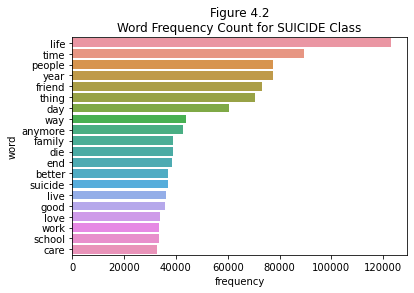

In [87]:
data_s = data_s.head(20)
sns.barplot(x='frequency',y='word',data=data_s).set(title='Word Frequency Count for SUICIDE Class')

Figure 4.2 shows that the top 3 most frequently mentioned words in the suicide class are '**life**', '**time**', and '**people**'. 

### **Non-Suicide Statements Containing the Word 'life'**

A dataframe, *ns_life*, is created to show all of the statements in the non-suicide class that contains the word *'life'*.

In [88]:
ns_life = ns_4[ns_4["text"].str.contains("life")]
ns_life

,text
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
8,'The reason I have faith in our species abilit...
20,'I hope you both can read this. Reading both o...
29,'Then maybe returningt there might be the firs...
...,...
231950,How 2020 ruined me Felt like reflecting on the...
232028,Got Friend zoned after talking to a girl for a...
232035,How in the fuck should I go about coming out t...
232045,"Bruh, imagine being Aaron Burr in the afterlif..."


To determine how many statements contain the word 'life', the shape of the dataframe is taken using .shape.

In [89]:
ns_life.shape

(6929, 1)

Results show that **6,929 statements in the non-suicide class contain the word 'life'**.

### **Non-Suicide Statements Containing the Word 'time'**

*ns_time* dataframe is a dataframe with all of the statements under the non-suicide class containing the word '*time*'. 

In [90]:
ns_time = ns_4[ns_4["text"].str.contains("time")]
ns_time

,text
0,"'Its not a viable option, and youll be leaving..."
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
8,'The reason I have faith in our species abilit...
11,"'Whats up? Tell me. Im here for you. ', 'Wow. ..."
...,...
232028,Got Friend zoned after talking to a girl for a...
232035,How in the fuck should I go about coming out t...
232036,Should I go back to my high school or should I...
232047,"My cat just died. My cat, Strawberry, just pas..."


*.shape* is used to know the number of statements or rows in the *ns_time* dataframe containing the word '*time*'.

In [91]:
ns_time.shape

(15827, 1)

Results show that **there are 15,827 statements that contain the word 'time'**.

### **Non-Suicide Statements Containing the Word 'people'**

A dataframe, *ns_people*, is created to show all of the statements in the non-suicide class containing the word '*people*'.

In [120]:
ns_people = ns_4[ns_4["text"].str.contains("people")]
ns_people

,text
5,"'Since I dont know what DBT is, would you mind..."
6,"'No matter what you ever think, there will be ..."
11,"'Whats up? Tell me. Im here for you. ', 'Wow. ..."
20,'I hope you both can read this. Reading both o...
29,'Then maybe returningt there might be the firs...
...,...
232009,I don't know what triggered this huge influx o...
232019,I am going to get some peope their ass I feel ...
232021,Offering help I'm just putting this out there ...
232028,Got Friend zoned after talking to a girl for a...


In determining the number of rows or statements with the word '*people*', *.shape* is used.

In [121]:
ns_people.shape

(14148, 1)

Results show that **there are 14,148 statements under the non-suicide class containing the word 'people'**.

In conclusion, **there are statements in the non-suicide class containing the top 3 most frequent words in the suicide class**: life, time, and people. There are 6,929 statements containing 'life', 15,827 statements containing 'time', and 14,148 statements containing the word 'people'.

## **5. What are the sentiment score of the statements per class?**

A copy of the non-suicide (ns) and suicide (s) class dataframes were created for this section under the names ns_SA and s_SA, respectively.

In [89]:
ns_SA = ns.copy(deep=True)
s_SA = s.copy(deep=True)

### **Non-Suicide Class**

Initially, the text column in the dataframe is fixed by converting all characters to lowercase using *.lower()*. Then, it undergoes tokenization using **RegexpTokenizer** so the sentiment analysis can occur at a token level.

In [180]:
ns_SA['text'] = ns_SA['text'].astype(str).str.lower()
regexp = RegexpTokenizer('\w+')

In [181]:
ns_SA['text_token']=ns_SA['text'].apply(regexp.tokenize)

Another column is added to the dataframe as tokenized statements are joined into a text string, but Stopwords are used beforehand to remove unnecessary words and improve processing speed.

In [184]:
stopwords = nltk.corpus.stopwords.words("english")

In [185]:
my_stopwords = ['https']
stopwords.extend(my_stopwords)

In [186]:
ns_SA['text_token'] = ns_SA['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
ns_SA['text_string'] = ns_SA['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

In [187]:
ns_SA[['text', 'text_token', 'text_string']]

,text,text_token,text_string
0,"'its not a viable option, and youll be leaving...","[viable, option, youll, leaving, wife, behind,...",viable option youll leaving wife behind youd p...
5,"'since i dont know what dbt is, would you mind...","[since, dont, know, dbt, would, mind, explaini...",since dont know dbt would mind explaining litt...
6,"'no matter what you ever think, there will be ...","[matter, ever, think, people, care, whether, p...",matter ever think people care whether people l...
8,'the reason i have faith in our species abilit...,"[reason, faith, species, ability, spread, surv...",reason faith species ability spread survive ho...
11,"'whats up? tell me. im here for you. ', 'wow. ...","[whats, tell, im, wow, cant, imagine, heavy, m...",whats tell wow cant imagine heavy must cancer ...
...,...,...,...
232068,i did something today i went sledding with my ...,"[something, today, went, sledding, friends, ma...",something today went sledding friends may seem...
232069,if you don't like rock then your not going to ...,"[like, rock, going, get, anything, go]",like rock going get anything
232070,you how you can tell i have so many friends an...,"[tell, many, friends, lonely, everything, depr...",tell many friends lonely everything deprived p...
232071,pee probably tastes like salty tea😏💦‼️ can som...,"[pee, probably, tastes, like, salty, tea, some...",pee probably tastes like salty tea someone dra...


The tokenized text will be re-tokenized using the *nltk tokenize package*, this time according to space and punctuation. Furthermore, *FreqDist* is applied to determine the frequency of each words in a statement. After that, lemmatization is applied  using *WordNetLemmatizer()* so that words of the same base will count as one.

In [188]:
all_words = ' '.join([word for word in ns_SA['text_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)

fdist = FreqDist(tokenized_words)

ns_SA['text_string_fdist'] = ns_SA['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))
ns_SA[['text', 'text_token', 'text_string', 'text_string_fdist']].tail()

,text,text_token,text_string,text_string_fdist
232068,i did something today i went sledding with my ...,"[something, today, went, sledding, friends, ma...",something today went sledding friends may seem...,something today went sledding friends may seem...
232069,if you don't like rock then your not going to ...,"[like, rock, going, get, anything, go]",like rock going get anything,like rock going get anything
232070,you how you can tell i have so many friends an...,"[tell, many, friends, lonely, everything, depr...",tell many friends lonely everything deprived p...,tell many friends lonely everything deprived p...
232071,pee probably tastes like salty tea😏💦‼️ can som...,"[pee, probably, tastes, like, salty, tea, some...",pee probably tastes like salty tea someone dra...,pee probably tastes like salty tea someone dra...
232073,i still haven't beaten the first boss in hollo...,"[still, beaten, first, boss, hollow, knight, f...",still beaten first boss hollow knight fought t...,still beaten first boss hollow knight fought t...


In [189]:
wordnet_lem = WordNetLemmatizer()

ns_SA['text_string_lem'] = ns_SA['text_string_fdist'].apply(wordnet_lem.lemmatize)

# check if the columns are equal
ns_SA['is_equal']= (ns_SA['text_string_fdist']==ns_SA['text_string_lem'])
# show level count
ns_SA.is_equal.value_counts()

True     121251
False        15
Name: is_equal, dtype: int64

**Sentiment analysis** is done on the lemmatized text string, where the *negative*, *neutral*, *positive*, and *compound* scores are created into columns. **The compound score serves as the overall score of the statement**. In this section, 2 Sentiment Analysis methods will be used — **NLTK Sentiment Analysis** and **VADER Sentiment Intensity Analyzer**.

#### **NLTK Sentiment Analysis**

In [190]:
analyzer = SentimentIntensityAnalyzer()

ns_SA['polarity'] = ns_SA['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))

# Change data structure
ns_SA = pd.concat(
     [ns_SA.drop(['polarity'], axis=1), 
     ns_SA['polarity'].apply(pd.Series)], axis=1)

The sentiment of each statement is classified according to their compound score. 

In [191]:
def condition(x):
    if x>0:
        return "positive"
    elif x==0:
        return "neutral"
    else:
        return 'negative'

ns_SA['sentiment'] = ns_SA['compound'].apply(condition)

ns_SA.tail()

,class,text,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound,sentiment
232068,0,i did something today i went sledding with my ...,"[something, today, went, sledding, friends, ma...",something today went sledding friends may seem...,something today went sledding friends may seem...,something today went sledding friends may seem...,True,0.000,0.457,0.543,0.8979,positive
232069,0,if you don't like rock then your not going to ...,"[like, rock, going, get, anything, go]",like rock going get anything,like rock going get anything,like rock going get anything,True,0.000,0.615,0.385,0.3612,positive
232070,0,you how you can tell i have so many friends an...,"[tell, many, friends, lonely, everything, depr...",tell many friends lonely everything deprived p...,tell many friends lonely everything deprived p...,tell many friends lonely everything deprived p...,True,0.284,0.558,0.157,-0.3612,negative
232071,0,pee probably tastes like salty tea😏💦‼️ can som...,"[pee, probably, tastes, like, salty, tea, some...",pee probably tastes like salty tea someone dra...,pee probably tastes like salty tea someone dra...,pee probably tastes like salty tea someone dra...,True,0.000,0.783,0.217,0.3612,positive
232073,0,i still haven't beaten the first boss in hollo...,"[still, beaten, first, boss, hollow, knight, f...",still beaten first boss hollow knight fought t...,still beaten first boss hollow knight fought t...,still beaten first boss hollow knight fought t...,True,0.604,0.396,0.000,-0.9354,negative


The total number of the positive, negative, and neutral statements are explored using *.value_counts()*. It shows that **most of the statements in the non-suicide class are classified to have a positive sentiment**. A bar plot is created to visualize the count.

In [173]:
ns_SA['sentiment'].value_counts()

positive    63899
negative    43698
neutral     13669
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Figure 6.1\nNon-Suicide Class Sentiment Text Values by Counts')

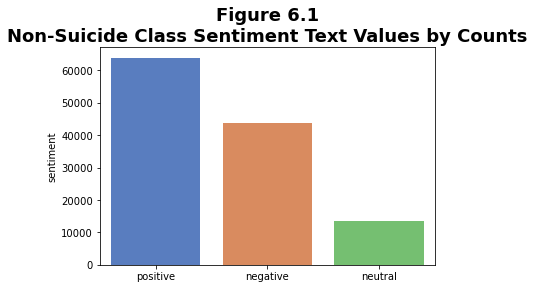

In [220]:
sns.set_palette('muted')
ax = sns.barplot(x=ns_SA['sentiment'].value_counts().index, y=ns_SA['sentiment'].value_counts())
ax.set_title('Non-Suicide Class Sentiment Text Values by Counts', fontsize=18, fontweight='bold')

#### **VADER Sentiment Intensity Analyzer**

the sentimenet analyzer for vader has to be imported to this part of the notebook since the nltk and the vader sentiment analyzer have the same name.

In [ ]:
nltk.download('vader_lexicon')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

The sentiment intensity analyzer is implemented.

In [204]:
vader_analyzer = SentimentIntensityAnalyzer()

def get_vsentiment_score(ns_SA_text):
    sentiment_score = vader_analyzer.polarity_scores(ns_SA_text)
    return sentiment_score

ns_SA['VADER_sentiment_score'] = ns_SA['text_string_lem'].apply(get_vsentiment_score)
ns_SA['neg_score'] = ns_SA['VADER_sentiment_score'].apply(lambda x: x['neg'])
ns_SA['neu_score'] = ns_SA['VADER_sentiment_score'].apply(lambda x: x['neu'])
ns_SA['pos_score'] = ns_SA['VADER_sentiment_score'].apply(lambda x: x['pos'])
ns_SA['compound_score'] = ns_SA['VADER_sentiment_score'].apply(lambda x: x['compound'])

The overall sentiment of a statement is classified according to the compound score generated by the vader sentiment intensity analyzer.

In [206]:
def condition(x):
    if x>0:
        return "positive"
    elif x==0:
        return "neutral"
    else:
        return 'negative'

ns_SA['VADER_sentiment'] = ns_SA['compound_score'].apply(condition)

ns_SA.tail()

,class,text,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound,sentiment,VADER_sentiment_score,neg_score,pos_score,neu_score,compound_score,VADER_sentiment
232068,0,i did something today i went sledding with my ...,"[something, today, went, sledding, friends, ma...",something today went sledding friends may seem...,something today went sledding friends may seem...,something today went sledding friends may seem...,True,0.000,0.457,0.543,0.8979,positive,"{'neg': 0.0, 'neu': 0.457, 'pos': 0.543, 'comp...",0.000,0.543,0.457,0.8979,positive
232069,0,if you don't like rock then your not going to ...,"[like, rock, going, get, anything, go]",like rock going get anything,like rock going get anything,like rock going get anything,True,0.000,0.615,0.385,0.3612,positive,"{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'comp...",0.000,0.385,0.615,0.3612,positive
232070,0,you how you can tell i have so many friends an...,"[tell, many, friends, lonely, everything, depr...",tell many friends lonely everything deprived p...,tell many friends lonely everything deprived p...,tell many friends lonely everything deprived p...,True,0.284,0.558,0.157,-0.3612,negative,"{'neg': 0.284, 'neu': 0.558, 'pos': 0.157, 'co...",0.284,0.157,0.558,-0.3612,negative
232071,0,pee probably tastes like salty tea😏💦‼️ can som...,"[pee, probably, tastes, like, salty, tea, some...",pee probably tastes like salty tea someone dra...,pee probably tastes like salty tea someone dra...,pee probably tastes like salty tea someone dra...,True,0.000,0.783,0.217,0.3612,positive,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",0.000,0.217,0.783,0.3612,positive
232073,0,i still haven't beaten the first boss in hollo...,"[still, beaten, first, boss, hollow, knight, f...",still beaten first boss hollow knight fought t...,still beaten first boss hollow knight fought t...,still beaten first boss hollow knight fought t...,True,0.604,0.396,0.000,-0.9354,negative,"{'neg': 0.604, 'neu': 0.396, 'pos': 0.0, 'comp...",0.604,0.000,0.396,-0.9354,negative


The number of positive, neutral, and negative statements are totalled using **.value_counts()**.

In [207]:
ns_SA['VADER_sentiment'].value_counts()

positive    64070
negative    43563
neutral     13633
Name: VADER_sentiment, dtype: int64

A barplot of the statements classified according to their VADER sentiment scores is shown below in figure 6.2

Text(0.5, 1.0, 'Figure 6.2\nNon-Suicide Class VADER Sentiment Text Values by Counts')

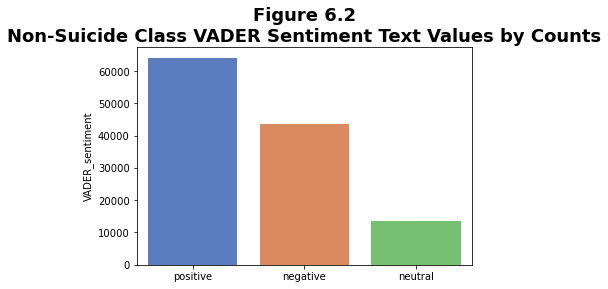

In [221]:
sns.set_palette('muted')
ax = sns.barplot(x=ns_SA['VADER_sentiment'].value_counts().index, y=ns_SA['VADER_sentiment'].value_counts())
ax.set_title('Non-Suicide Class VADER Sentiment Text Values by Counts', fontsize=18, fontweight='bold')

Since the total counts for the positive, neutral , and negative statements are varying, the statements that has a different sentiment classification as per NLTK sentiment analysis and VADER sentiment intensity analyzer are listed below.

In [216]:
mask_ns = ns_SA['sentiment'] != ns_SA['VADER_sentiment']
mismatched_rows = ns_SA[mask]
mismatched_rows. drop(["class", "text", "text_token", "text_string", "text_string_fdist", "is_equal", "neg", "neu", "pos", "compound", "VADER_sentiment_score", "neg_score", "neu_score", "pos_score", "compound_score"], axis=1)

,text_string_lem,sentiment,VADER_sentiment
40,arrested wasnt good student good offspring rea...,negative,positive
55,another thing feel dont enough friends sign so...,negative,positive
494,better half put situation understand depressed...,positive,negative
3642,mcprusa lives always hearts goodbye puerto rico,neutral,positive
4792,dad wanted run trained hard doc said stop hear...,negative,positive
...,...,...,...
230332,developing new break strategy think recently f...,negative,positive
230553,someone gives awardee karma get notification r...,negative,positive
231171,get erection girlfriend 16m f16 agreed sex con...,negative,positive
231292,fuck guess shorter thought moter decided make ...,negative,positive


### **Suicide Class**

The dataframe's text column is initially adjusted by using the *.lower()* function to lowercase all characters. Then, it is tokenized using *RegexpTokenizer* so that token-level sentiment analysis may take place.

In [90]:
s_SA['text'] = s_SA['text'].astype(str).str.lower()
regexp = RegexpTokenizer('\w+')

In [91]:
s_SA['text_token']=s_SA['text'].apply(regexp.tokenize)

The statements will be tokenized and then rejoined into a text string. To reduce the number of words that need to be processed, Stopwords are applied prior to joining it. hence, faster results.

In [ ]:
s_SA['text_token'] = s_SA['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
s_SA['text_string'] = s_SA['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

In [253]:
s_SA[['text', 'text_token', 'text_string']]

,text,text_token,text_string
1,'it can be hard to appreciate the notion that ...,"[hard, appreciate, notion, could, meet, someon...",hard appreciate notion could meet someone else...
2,"'hi, so last night i was sitting on the ledge ...","[hi, last, night, sitting, ledge, window, cont...",last night sitting ledge window contemplating ...
3,'i tried to kill my self once and failed badly...,"[tried, kill, self, failed, badly, cause, mome...",tried kill self failed badly cause moment want...
4,'hi nem3030. what sorts of things do you enjoy...,"[hi, nem3030, sorts, things, enjoy, personally...",nem3030 sorts things enjoy personally always w...
7,"'dont see it as failing at killing yourself, t...","[dont, see, failing, killing, theres, reason, ...",dont see failing killing theres reason lived t...
...,...,...,...
232061,i’ve fucking had enough.none of this depressio...,"[fucking, enough, none, depression, subs, help...",fucking enough none depression subs helped ugl...
232062,paralyzing anxiety &amp; depression are pushin...,"[paralyzing, anxiety, amp, depression, pushing...",paralyzing anxiety amp depression pushing edge...
232066,my mom tried to kill herself today. i feel los...,"[mom, tried, kill, today, feel, lost, second, ...",mom tried kill today feel lost second time hap...
232067,i’m a fucking scummy person and i can’t change...,"[fucking, scummy, person, change, itever, sinc...",fucking scummy person change itever since kid ...


Using the *nltk tokenize package*, the tokenized text will be re-tokenized, this time taking space and punctuation into account. Additionally, the application of *FreqDist* is used to ascertain the frequency of each word in a sentence. Following that, words with the same base are lemmatized using *WordNetLemmatizer()* so that they only count as one.

In [254]:
all_words = ' '.join([word for word in s_SA['text_string']])

In [255]:
s_SA['text_string_fdist'] = s_SA['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))
s_SA[['text', 'text_token', 'text_string', 'text_string_fdist']].tail()

,text,text_token,text_string,text_string_fdist
232061,i’ve fucking had enough.none of this depressio...,"[fucking, enough, none, depression, subs, help...",fucking enough none depression subs helped ugl...,fucking enough none depression subs helped ugl...
232062,paralyzing anxiety &amp; depression are pushin...,"[paralyzing, anxiety, amp, depression, pushing...",paralyzing anxiety amp depression pushing edge...,paralyzing anxiety amp depression pushing edge...
232066,my mom tried to kill herself today. i feel los...,"[mom, tried, kill, today, feel, lost, second, ...",mom tried kill today feel lost second time hap...,mom tried kill today feel lost second time hap...
232067,i’m a fucking scummy person and i can’t change...,"[fucking, scummy, person, change, itever, sinc...",fucking scummy person change itever since kid ...,fucking scummy person change since kid get tro...
232072,the usual stuff you find herei'm not posting t...,"[usual, stuff, find, herei, posting, sympathy,...",usual stuff find herei posting sympathy pity k...,usual stuff find posting sympathy pity know fa...


In [256]:
s_SA['text_string_lem'] = s_SA['text_string_fdist'].apply(wordnet_lem.lemmatize)

In [257]:
# check if the columns are equal
s_SA['is_equal']= (s_SA['text_string_fdist']==s_SA['text_string_lem'])
# show level count
s_SA.is_equal.value_counts()

True     120884
False        10
Name: is_equal, dtype: int64

The lemmatized text string is subjected to **sentiment analysis**, and columns are generated for the *negative*, *neutral*, *positive*, and *compound* scores. The statement is given an overall score based on its compound score. Two sentiment analysis methods will be compared to each other — NLTK Sentiment Analysis and VADER Sentiment Intensity Analyzer.

#### **NLTK Sentiment Analysis**

In [258]:
s_SA['polarity'] = s_SA['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))

# Change data structure
s_SA = pd.concat(
     [s_SA.drop(['polarity'], axis=1), 
     s_SA['polarity'].apply(pd.Series)], axis=1)

According to their compound score, each statement's sentiment is categorized. 

In [260]:
s_SA['sentiment'] = s_SA['compound'].apply(condition)

s_SA.tail()

,class,text,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound,sentiment
232061,1,i’ve fucking had enough.none of this depressio...,"[fucking, enough, none, depression, subs, help...",fucking enough none depression subs helped ugl...,fucking enough none depression subs helped ugl...,fucking enough none depression subs helped ugl...,True,0.468,0.475,0.057,-0.9696,negative
232062,1,paralyzing anxiety &amp; depression are pushin...,"[paralyzing, anxiety, amp, depression, pushing...",paralyzing anxiety amp depression pushing edge...,paralyzing anxiety amp depression pushing edge...,paralyzing anxiety amp depression pushing edge...,True,0.235,0.586,0.179,-0.9966,negative
232066,1,my mom tried to kill herself today. i feel los...,"[mom, tried, kill, today, feel, lost, second, ...",mom tried kill today feel lost second time hap...,mom tried kill today feel lost second time hap...,mom tried kill today feel lost second time hap...,True,0.326,0.481,0.194,-0.9169,negative
232067,1,i’m a fucking scummy person and i can’t change...,"[fucking, scummy, person, change, itever, sinc...",fucking scummy person change itever since kid ...,fucking scummy person change since kid get tro...,fucking scummy person change since kid get tro...,True,0.398,0.522,0.080,-0.9823,negative
232072,1,the usual stuff you find herei'm not posting t...,"[usual, stuff, find, herei, posting, sympathy,...",usual stuff find herei posting sympathy pity k...,usual stuff find posting sympathy pity know fa...,usual stuff find posting sympathy pity know fa...,True,0.288,0.514,0.198,-0.9679,negative


Using *.value_counts()*, the total number of the positive negative, and neutral statements is examined. It shows that **the majority of the suicide statements are categorized as having negative sentiment**. The count is represented visually via a barplot.

In [261]:
s_SA['sentiment'].value_counts()

negative    83217
positive    35816
neutral      1861
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Figure 6.3\nSuicide Class Sentiment Text Values by Counts')

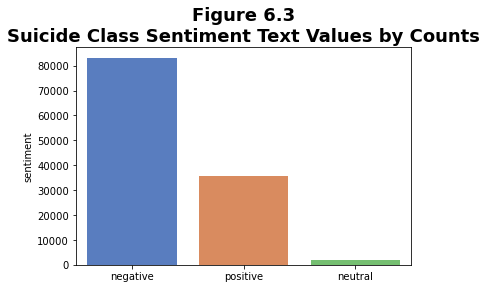

In [262]:
sns.set_palette('muted')
ax = sns.barplot(x=s_SA['sentiment'].value_counts().index, y=s_SA['sentiment'].value_counts())
ax.set_title('Suicide Class Sentiment Text Values by Counts', fontsize=18, fontweight='bold')

#### VADER Sentiment Intensity Analyzer

The VADER sintiment intensity analyzer is used as a function to get the sentiment scores of the dataframe. 

In [263]:
def get_vsentiment_score(s_SA_text):
    sentiment_score_s = vader_analyzer.polarity_scores(s_SA_text)
    return sentiment_score_s

s_SA['VADER_sentiment_score'] = s_SA['text_string_lem'].apply(get_vsentiment_score)
s_SA['neg_score'] = s_SA['VADER_sentiment_score'].apply(lambda x: x['neg'])
s_SA['neu_score'] = s_SA['VADER_sentiment_score'].apply(lambda x: x['neu'])
s_SA['pos_score'] = s_SA['VADER_sentiment_score'].apply(lambda x: x['pos'])
s_SA['compound_score'] = s_SA['VADER_sentiment_score'].apply(lambda x: x['compound'])

After getting the compound scores of the statements, each statement is classified either as *positive*, *neutral*, or *negative* depending on their compound score as determined by VADER sentiment intensity analyzer.

In [264]:
def condition(x):
    if x>0:
        return "positive"
    elif x==0:
        return "neutral"
    else:
        return 'negative'

s_SA['VADER_sentiment'] = s_SA['compound_score'].apply(condition)

s_SA.tail()

,class,text,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound,sentiment,VADER_sentiment_score,neg_score,neu_score,pos_score,compound_score,VADER_sentiment
232061,1,i’ve fucking had enough.none of this depressio...,"[fucking, enough, none, depression, subs, help...",fucking enough none depression subs helped ugl...,fucking enough none depression subs helped ugl...,fucking enough none depression subs helped ugl...,True,0.468,0.475,0.057,-0.9696,negative,"{'neg': 0.468, 'neu': 0.475, 'pos': 0.057, 'co...",0.468,0.475,0.057,-0.9696,negative
232062,1,paralyzing anxiety &amp; depression are pushin...,"[paralyzing, anxiety, amp, depression, pushing...",paralyzing anxiety amp depression pushing edge...,paralyzing anxiety amp depression pushing edge...,paralyzing anxiety amp depression pushing edge...,True,0.235,0.586,0.179,-0.9966,negative,"{'neg': 0.235, 'neu': 0.586, 'pos': 0.179, 'co...",0.235,0.586,0.179,-0.9966,negative
232066,1,my mom tried to kill herself today. i feel los...,"[mom, tried, kill, today, feel, lost, second, ...",mom tried kill today feel lost second time hap...,mom tried kill today feel lost second time hap...,mom tried kill today feel lost second time hap...,True,0.326,0.481,0.194,-0.9169,negative,"{'neg': 0.326, 'neu': 0.481, 'pos': 0.194, 'co...",0.326,0.481,0.194,-0.9169,negative
232067,1,i’m a fucking scummy person and i can’t change...,"[fucking, scummy, person, change, itever, sinc...",fucking scummy person change itever since kid ...,fucking scummy person change since kid get tro...,fucking scummy person change since kid get tro...,True,0.398,0.522,0.080,-0.9823,negative,"{'neg': 0.398, 'neu': 0.522, 'pos': 0.08, 'com...",0.398,0.522,0.080,-0.9823,negative
232072,1,the usual stuff you find herei'm not posting t...,"[usual, stuff, find, herei, posting, sympathy,...",usual stuff find herei posting sympathy pity k...,usual stuff find posting sympathy pity know fa...,usual stuff find posting sympathy pity know fa...,True,0.288,0.514,0.198,-0.9679,negative,"{'neg': 0.288, 'neu': 0.514, 'pos': 0.198, 'co...",0.288,0.514,0.198,-0.9679,negative


**.value_counts()** of the statements per classification is identified to compare it with the classification done by the NLTK sentiment analyzer.

In [265]:
s_SA['VADER_sentiment'].value_counts()

negative    83217
positive    35816
neutral      1861
Name: VADER_sentiment, dtype: int64

It shows that both the NLTK sentiment analyzer and VADER sentiment intensity analyzer was able to classify the statements into **83,217 negative statements**, **35,816 positive statements**, and **1,861 neutral statements**.

Text(0.5, 1.0, 'Figure 6.4\nSuicide Class VADER Sentiment Text Values by Counts')

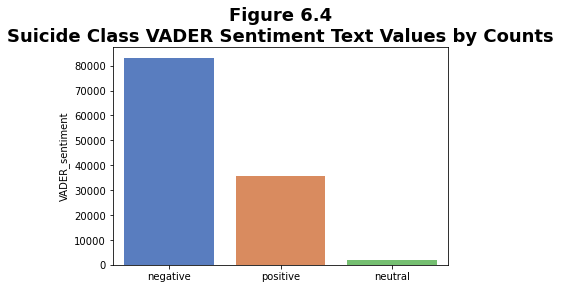

In [267]:
sns.set_palette('muted')
ax = sns.barplot(x=s_SA['VADER_sentiment'].value_counts().index, y=s_SA['VADER_sentiment'].value_counts())
ax.set_title('Suicide Class VADER Sentiment Text Values by Counts', fontsize=18, fontweight='bold')


It is observed that the barplot for the NLTK and VADER sentiment analysis shows similar results. **Majority of the statements for the Suicide Class is identified to be negative** whereas there is little known neutral statements.

Overall, the both NLTK and VADER were able to categorize the statements into their respective sentiment categories. In the case of the Non-Suicide Class, the sentiment of the statements did not match possibly due to gaps and ambiguities in the statements. However, the overall performance of both NLTK and VADER was quite good in classifying the sentiment of the statements.

## **Conclusion**

It is important to ensure that the datasets have uniform data types and dealing with null values is important as it might affect the learning or prediction of our models. Furthermore, since our project deals with text, setting the data to be appropriate for the model is necessary. For example, bert base uncased requires the text data to be all lowercase.

A deeper understanding and study should be done for the models as the different models/nlp methods have different requirements and processes in order to do it properly. Other than that, by seeing the different models and methods showed the similarities and differences to preprocessing text data.

It was evident how important tokenization and lemmatization is in EDA. Tokenization involves splitting the text into individual words or tokens, while lemmatization involves reducing the words to their base form. Since a statement is composed of numerous words, it is important to reduce the size of the text and identify which words are important to make the sentiment analysis more meaningful. Furthermore, other preprocessing techniques such as stop-word removal and stemming can also contribute to the EDA's accuracy and comprehensiveness. In terms of sentiment analysis, it is necessary to know how important a word, the degree or severity 

Lastly, with regards to modeling, one of the most important things that we have learned is the importance of having a baseline to compare deep learning models to. This way, we could actually make an informed decision when determining the best model, especially since traditional machine learning models are more interpretable than deep learning models.  

## References

AbsentData. (n.d.). *Python Word Frequency Graph*. AbsentData. https://absentdata.com/python-graphs/python-word-frequency/

AI Black Belt. (2021, June 29). *Natural Language Processing*. Towards AI. https://pub.towardsai.net/natural-language-processing-c12b0d525f99

Aman Kharwal. (2019, March 19). *NLP Part-3: Exploratory Data Analysis of Text Data*. Towards Data Science. https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d

Anderson, M., & Jiang, J. (2018, November 28). *Teens’ Social Media Habits and Experiences.* Pew Research Center: Internet, Science & Tech. https://www.pewresearch.org/internet/2018/11/28/teens-social-media-habits-and-experiences/

Crosby, A., Ortega, L., & Melanson, C. (2011, February). *Self-directed violence surveillance; uniform definitions and recommended data elements.* Stacks.cdc.gov. https://stacks.cdc.gov/view/cdc/11997

Das, S. (2021, June 17). *VADER for Sentiment Analysis: A Beginner’s Guide*. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/06/vader-for-sentiment-analysis/

Singh, A. (2020, April 22). *Beginner’s Guide to Exploratory Data Analysis (EDA) on Text Data*. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

Turecki, G., Brent, D. A., Gunnell, D., O’Connor, R. C., Oquendo, M. A., Pirkis, J., & Stanley, B. H. (2019). Suicide and suicide risk. *Nature Reviews Disease Primers*, 5(1). https://doi.org/10.1038/s41572-019-0121-0